<a href="https://www.kaggle.com/code/ikram98ai/clothes-review-sentiment-with-automl-balzingtext?scriptVersionId=191261972" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Registering and visualizing clothe reviews dataset

In [2]:
!pip install --disable-pip-version-check -q sagemaker
!pip install --disable-pip-version-check -q pandas
!pip install --disable-pip-version-check -q awswrangler
!pip install --disable-pip-version-check -q numpy
!pip install --disable-pip-version-check -q seaborn
!pip install --disable-pip-version-check -q matplotlib
!pip install --disable-pip-version-check -q nltk
!pip install -q protobuf

## Ingest and transform the public dataset

### Copying the data locally to the notebook

In [ ]:
!aws s3 cp 's3://review-analysis/data/raw/womens_clothing_ecommerce_reviews.csv' ./

In [5]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
import botocore
from sagemaker import clarify
import awswrangler as wr
import time, json
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from IPython.core.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format='retina'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml

sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


/tmp/ipykernel_102/155177234.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display

  from IPython.core.display import display, HTML


In [6]:
config = botocore.config.Config(user_agent_extra='reviews/clothing')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
account_id = sess.account_id


df = pd.read_csv('./womens_clothing_ecommerce_reviews.csv',
                 index_col=0)

df.shape

(23486, 10)

In [7]:
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,It reminds me of maternity clothes. soft stre...,3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through",This fit well but the top was very see throug...,3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


### Transforming the data

In [8]:
# Transforming the data into a comma-separated value (CSV) file that contains only a `review_body`, `product_category`, and `sentiment`.
df_transformed = df.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df_transformed.dropna(inplace=True)

df_transformed.shape

(22628, 3)

In [9]:
# converting the `star_rating` into the `sentiment` (positive, neutral, negative)
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1

# transform star_rating into the sentiment
df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df_transformed.drop(columns=['star_rating'],
                    inplace=True)

# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_transformed.shape

(22626, 3)

In [10]:
# preview the results
df_transformed.groupby('product_category').count().sort_values('sentiment',ascending=False)

,sentiment,review_body
product_category,,
Dresses,6145,6145
Knits,4626,4626
Blouses,2983,2983
Sweaters,1380,1380
Pants,1350,1350
Jeans,1104,1104
Fine gauge,1059,1059
Skirts,903,903
Jackets,683,683


### Write the data to a CSV file

In [11]:
df_transformed.to_csv('./womens_clothing_ecommerce_reviews_transformed.csv', 
                      index=False)

In [12]:
!head -n 5 ./womens_clothing_ecommerce_reviews_transformed.csv

sentiment,review_body,product_category

1,If this product was in petite  i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that.     fits nicely! i'm 5'4  130lb and pregnant so i bough t medium to grow into.     the tie can be front or back so provides for some nice flexibility on form fitting.,Blouses

1,"Love this dress!  it's sooo pretty.  i happened to find it in a store  and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8"".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.",Dresses

0,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium  which was just ok. overall  the top half was comfortable and fit nicely  but the b

## Registering the public dataset for querying and visualizing

In [13]:
!aws s3 cp ./womens_clothing_ecommerce_reviews_transformed.csv s3://$bucket/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv

upload: ./womens_clothing_ecommerce_reviews_transformed.csv to s3://sagemaker-us-east-1-883663531372/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv


In [14]:
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed/#">Amazon S3 buckets</a></b>'.format(bucket, region)))

**Create AWS Glue Catalog database**

In [15]:
wr.catalog.create_database(
    name='clothing_reviews',
    exist_ok=True
)

In [16]:
dbs = wr.catalog.get_databases()

for db in dbs:
    print("Database name: " + db['Name'])

Database name: clothing_reviews


In [17]:
display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#catalog:tab=databases">AWS Glue Databases</a></b>'.format(region)))

**Register CSV data with AWS Glue Catalog**

In [18]:
wr.catalog.create_csv_table(
    database='clothing_reviews', 
    path='s3://{}/data/transformed/'.format(bucket), 
    table="reviews",    
    columns_types={
        'sentiment': 'int',        
        'review_body': 'string',
        'product_category': 'string'      
    },
    mode='overwrite',
    skip_header_line_count=1,
    sep=','
)

In [19]:
# Review the registered table in the AWS Glue Catalog.
display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(region)))

In [20]:
table = wr.catalog.table(database='clothing_reviews',
                         table='reviews')
table

,Column Name,Type,Partition,Comment
0,sentiment,int,False,
1,review_body,string,False,
2,product_category,string,False,


### Create default S3 bucket for Amazon Athena

In [21]:
# S3 bucket name
wr.athena.create_athena_bucket()

's3://aws-athena-query-results-883663531372-us-east-1/'

## Visualize data

**Reviews dataset - column descriptions**

- `sentiment`: The review's sentiment (-1, 0, 1).
- `product_category`: Broad product category that can be used to group reviews.
- `review_body`: The text of the review.

### Preparation for data visualization


In [22]:
database_name = 'clothing_reviews'
table_name = 'reviews'

**Run SQL queries using Amazon Athena**

### How many reviews per sentiment?

In [23]:
statement_count_by_sentiment = """
SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment
"""

print(statement_count_by_sentiment)



SELECT sentiment, COUNT(sentiment) AS count_sentiment

FROM reviews

GROUP BY sentiment

ORDER BY sentiment




In [24]:
df_count_by_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_sentiment,
    database=database_name
)

print(df_count_by_sentiment)

   sentiment  count_sentiment

0         -1             2370

1          0             2823

2          1            17433


<Axes: xlabel='sentiment'>

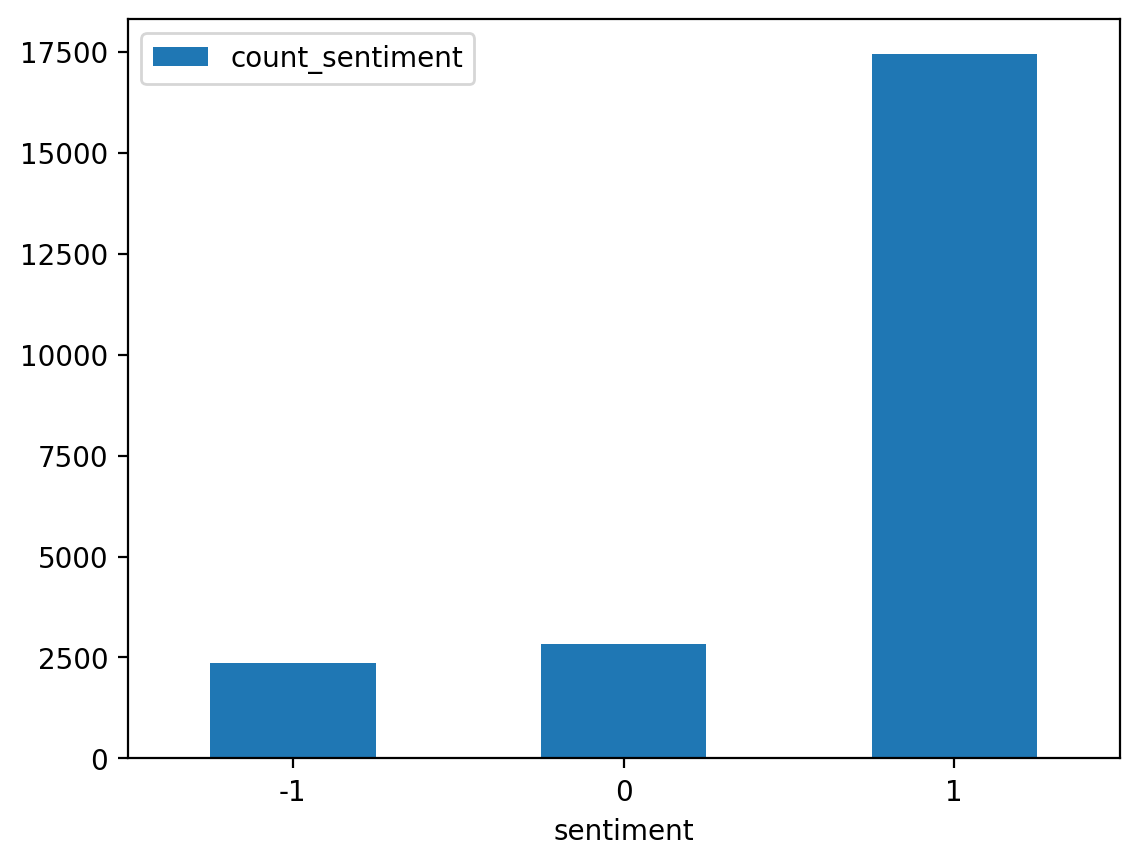

In [25]:
df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)

In [26]:
statement_count_by_category = """
SELECT product_category, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY product_category 
ORDER BY count_sentiment DESC
"""
print(statement_count_by_category)



SELECT product_category, COUNT(sentiment) AS count_sentiment

FROM reviews

GROUP BY product_category 

ORDER BY count_sentiment DESC




In [27]:
df = wr.athena.read_sql_query(sql='select * from reviews', database=database_name)
df.groupby('product_category').count().sort_values('sentiment',ascending=False)

,sentiment,review_body
product_category,,
Dresses,6145,6145
Knits,4626,4626
Blouses,2983,2983
Sweaters,1380,1380
Pants,1350,1350
Jeans,1104,1104
Fine gauge,1059,1059
Skirts,903,903
Jackets,683,683


In [28]:
%%time
df_count_by_category = wr.athena.read_sql_query(
    sql=statement_count_by_category,
    database=database_name
)

df_count_by_category

CPU times: user 252 ms, sys: 22.8 ms, total: 275 ms

Wall time: 3.49 s


,product_category,count_sentiment
0,Dresses,6145
1,Knits,4626
2,Blouses,2983
3,Sweaters,1380
4,Pants,1350
5,Jeans,1104
6,Fine gauge,1059
7,Skirts,903
8,Jackets,683
9,Lounge,669


### Which product categories are highest rated by average sentiment?

In [29]:
statement_avg_by_category = """
SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM {} 
GROUP BY product_category 
ORDER BY avg_sentiment DESC
""".format(table_name)

print(statement_avg_by_category)



SELECT product_category, AVG(sentiment) AS avg_sentiment

FROM reviews 

GROUP BY product_category 

ORDER BY avg_sentiment DESC




In [30]:
%%time
df_avg_by_category = wr.athena.read_sql_query(
    sql=statement_avg_by_category,
    database=database_name
)

CPU times: user 225 ms, sys: 16.7 ms, total: 242 ms

Wall time: 2.47 s


In [31]:
# Preview the query results in the temporary S3 bucket:  `s3://aws-athena-query-results-ACCOUNT-REGION/`
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/aws-athena-query-results-{}-{}?region={}">Amazon S3 buckets</a></b>'.format(account_id, region, region)))

In [32]:
df_avg_by_category

,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


**Visualization**

In [33]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

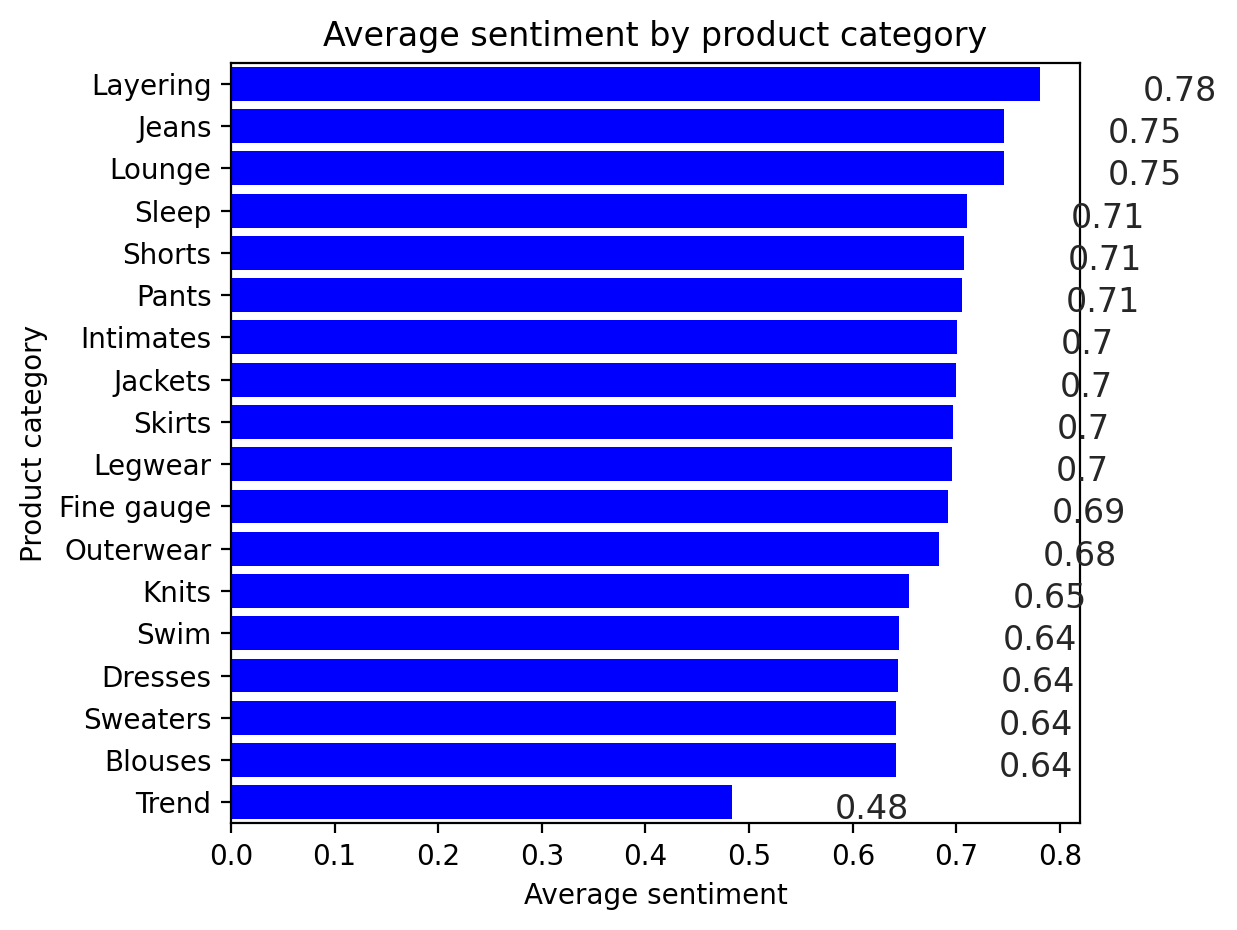

In [34]:
# Create plot
barplot = sns.barplot(
    data = df_avg_by_category, 
    y='product_category',
    x='avg_sentiment', 
    color="b", 
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title and x-axis ticks 
plt.title('Average sentiment by product category')

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average sentiment")
plt.ylabel("Product category")

plt.tight_layout()
plt.savefig('avg_sentiment_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

In [35]:
# Upload image to S3 bucket
sess.upload_data(path='avg_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-883663531372/images/avg_sentiment_per_category.png'

In [36]:
# Review the bucket on the account.
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}">Amazon S3 buckets</a></b>'.format(region)))

### Which product categories have the most reviews?

In [37]:
statement_count_by_category_desc = """
SELECT product_category, COUNT(*) AS count_reviews 
FROM {}
GROUP BY product_category 
ORDER BY count_reviews DESC
""".format(table_name)

print(statement_count_by_category_desc)



SELECT product_category, COUNT(*) AS count_reviews 

FROM reviews

GROUP BY product_category 

ORDER BY count_reviews DESC




In [38]:
%%time
df_count_by_category_desc = wr.athena.read_sql_query(
    sql=statement_count_by_category_desc,
    database=database_name
)

CPU times: user 453 ms, sys: 33.7 ms, total: 487 ms

Wall time: 3.69 s


In [39]:
max_sentiment = df_count_by_category_desc['count_reviews'].max()
print('Highest number of reviews (in a single category): {}'.format(max_sentiment))

Highest number of reviews (in a single category): 6145


### Plot number of reviews per product category.

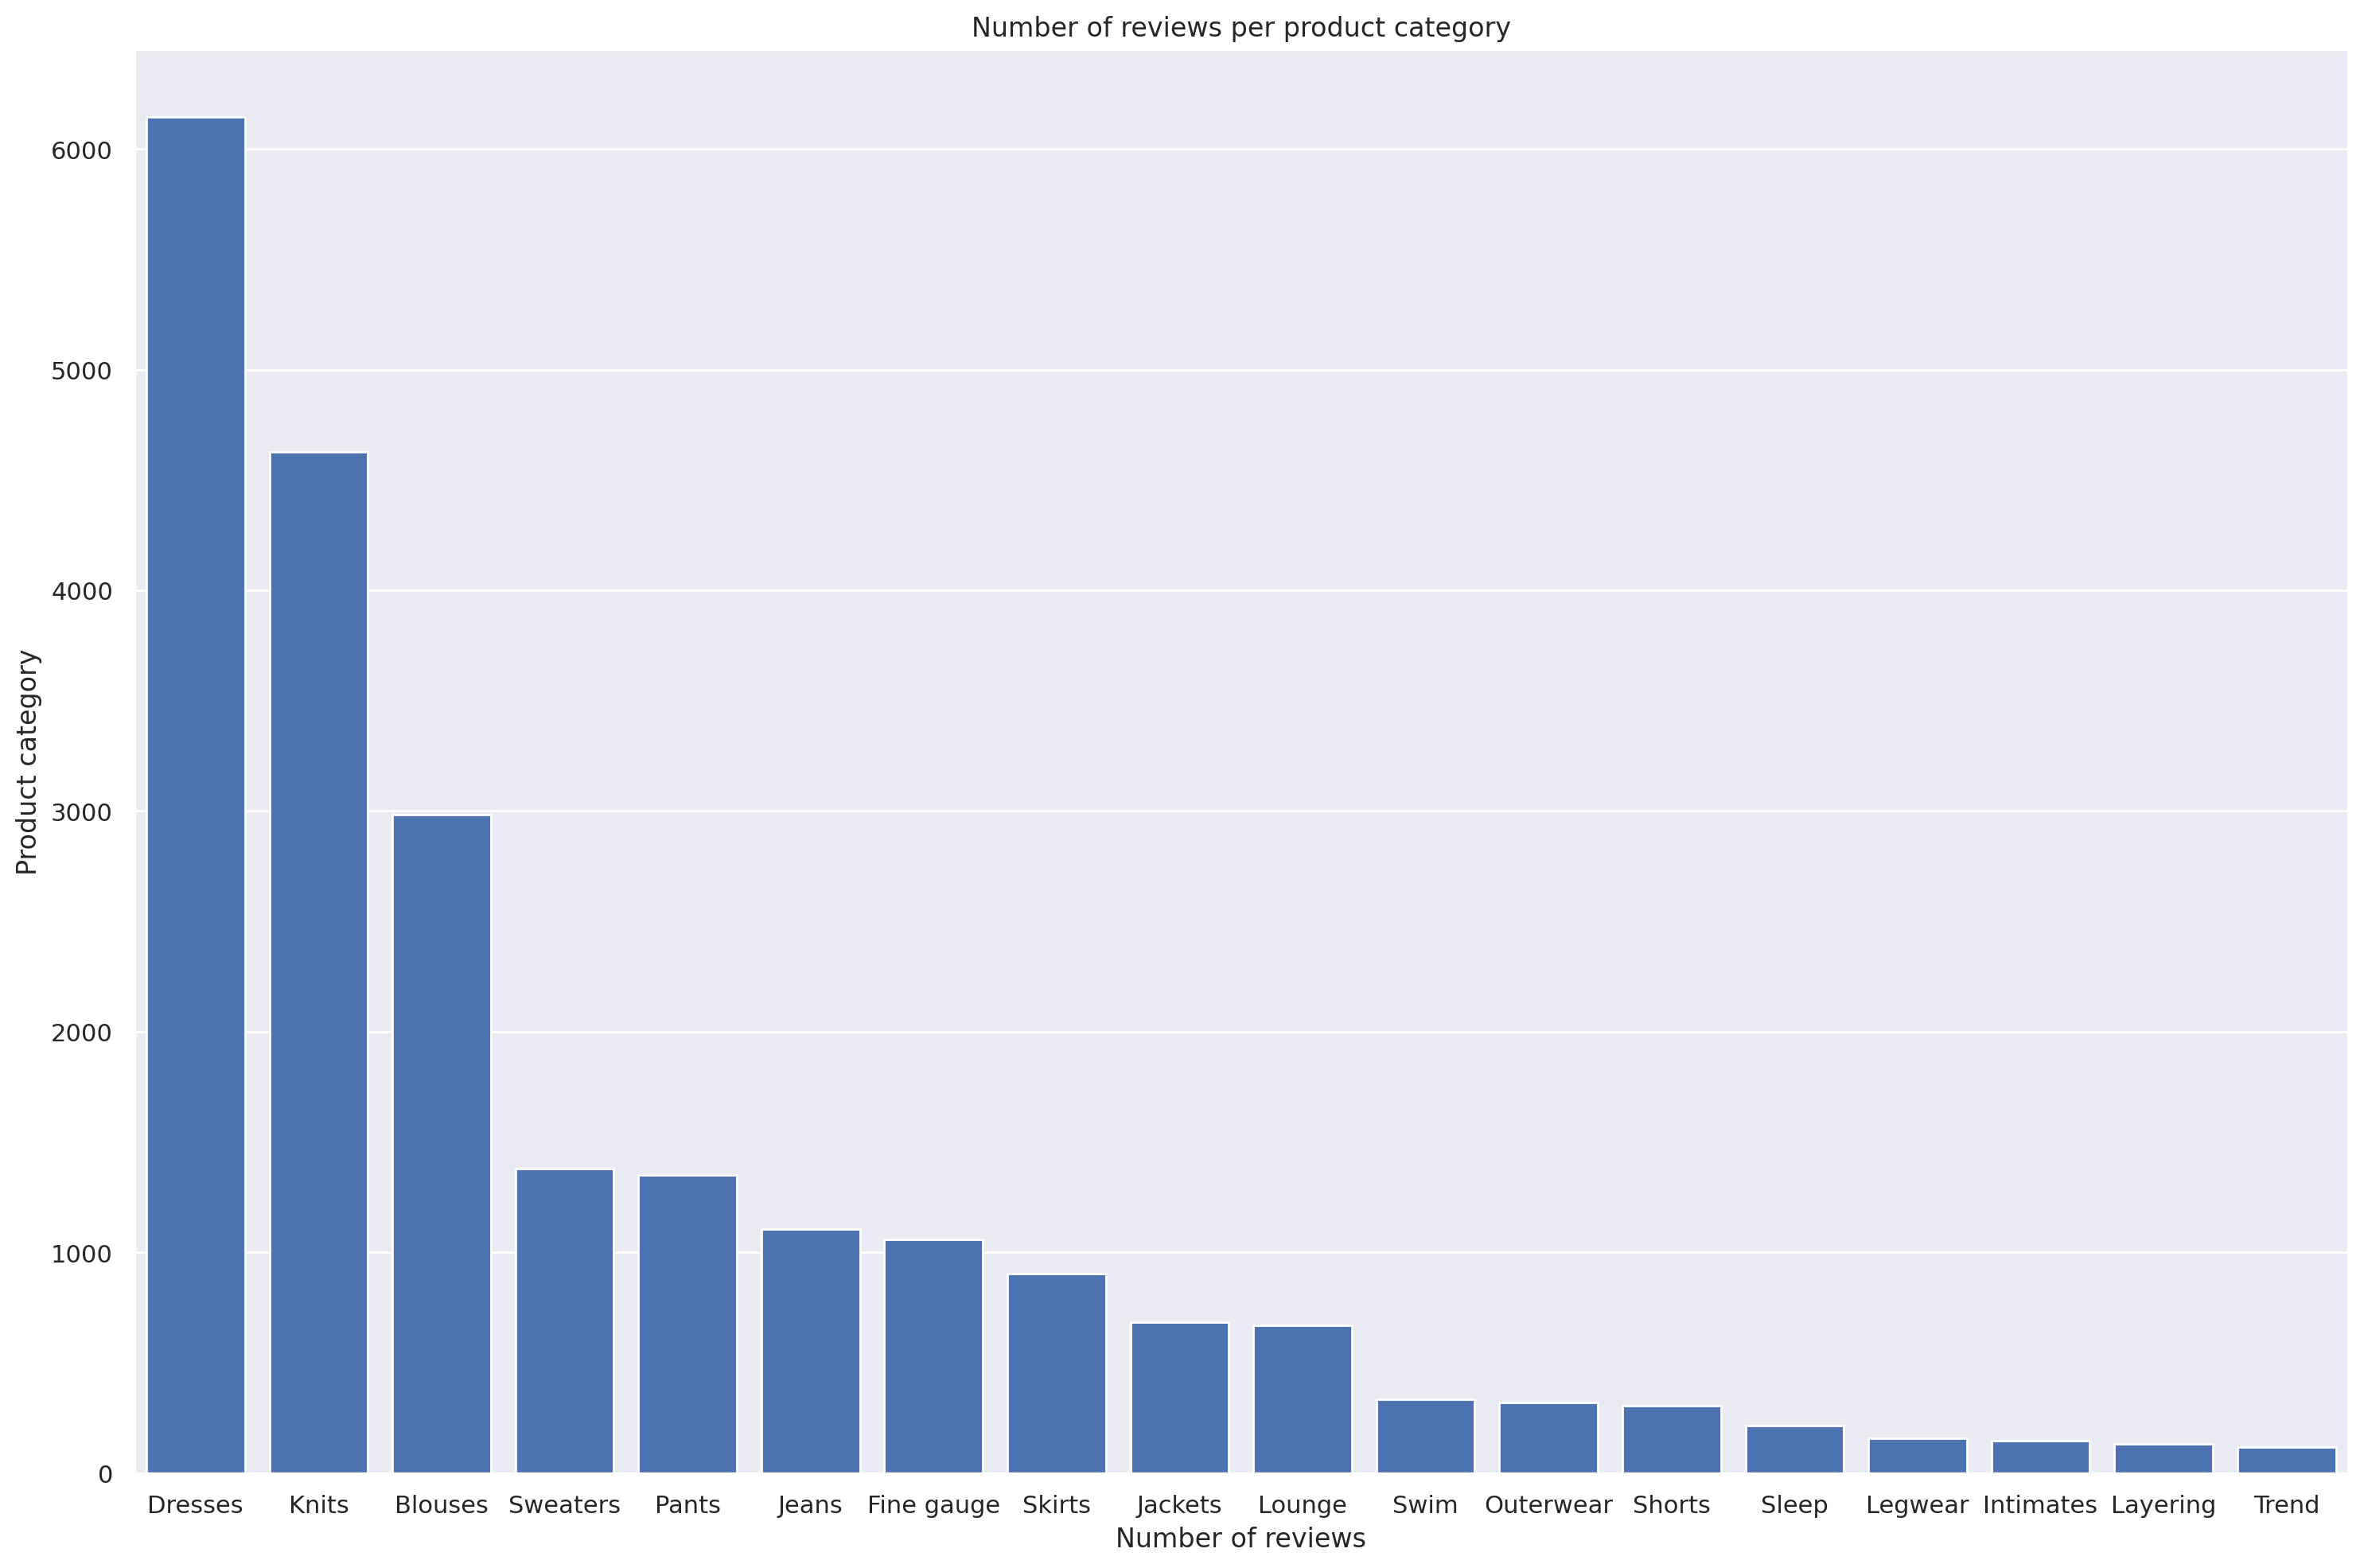

In [40]:
# Create seaborn barplot
barplot = sns.barplot(
    data=df_count_by_category_desc, 
    y='count_reviews', 
    x='product_category',
    color="b",
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")

plt.tight_layout()

plt.savefig('num_reviews_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [41]:
# Upload image to S3 bucket
sess.upload_data(path='num_reviews_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-883663531372/images/num_reviews_per_category.png'

### What is the breakdown of sentiments per product category?

In [42]:
statement_count_by_category_and_sentiment = """
SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM {}
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews
""".format(table_name)

print(statement_count_by_category_and_sentiment)



SELECT product_category,

         sentiment,

         COUNT(*) AS count_reviews

FROM reviews

GROUP BY  product_category, sentiment

ORDER BY  product_category ASC, sentiment DESC, count_reviews




In [43]:
%%time
df_count_by_category_and_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_category_and_sentiment,
    database=database_name
)

CPU times: user 267 ms, sys: 11.8 ms, total: 279 ms

Wall time: 3.5 s


In [44]:
# Create grouped dataframes by category and by sentiment
grouped_category = df_count_by_category_and_sentiment.groupby('product_category')
grouped_star = df_count_by_category_and_sentiment.groupby('sentiment')

# Create sum of sentiments per star sentiment
df_sum = df_count_by_category_and_sentiment.groupby(['sentiment']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22626


In [45]:
# Build array per star across all categories.
distribution = {}
count_reviews_per_star = []
i=0

for category, sentiments in grouped_category:
    count_reviews_per_star = []
    for star in sentiments['sentiment']:
        count_reviews_per_star.append(sentiments.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_star

In [46]:
distribution

{'Blouses': [2256, 384, 343],
 'Dresses': [4634, 830, 681],
 'Fine gauge': [837, 118, 104],
 'Intimates': [117, 16, 14],
 'Jackets': [550, 61, 72],
 'Jeans': [909, 110, 85],
 'Knits': [3523, 605, 498],
 'Layering': [113, 9, 10],
 'Legwear': [126, 16, 16],
 'Lounge': [545, 78, 46],
 'Outerwear': [254, 29, 36],
 'Pants': [1074, 154, 122],
 'Shorts': [240, 39, 25],
 'Skirts': [714, 104, 85],
 'Sleep': [175, 16, 23],
 'Sweaters': [1036, 193, 151],
 'Swim': [252, 42, 38],
 'Trend': [78, 19, 21]}

In [47]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['1', '0', '-1']
df_distribution_pct

,1,0,-1
Blouses,75.628562,12.872947,11.498491
Dresses,75.410903,13.506916,11.082181
Fine gauge,79.036827,11.142587,9.820585
Intimates,79.591837,10.884354,9.523810
Jackets,80.527086,8.931186,10.541728
Jeans,82.336957,9.963768,7.699275
Knits,76.156507,13.078253,10.765240
Layering,85.606061,6.818182,7.575758
Legwear,79.746835,10.126582,10.126582
Lounge,81.464873,11.659193,6.875934


**Visualization**

Ploting the distributions of sentiments per product category.

<Figure size 1000x500 with 0 Axes>

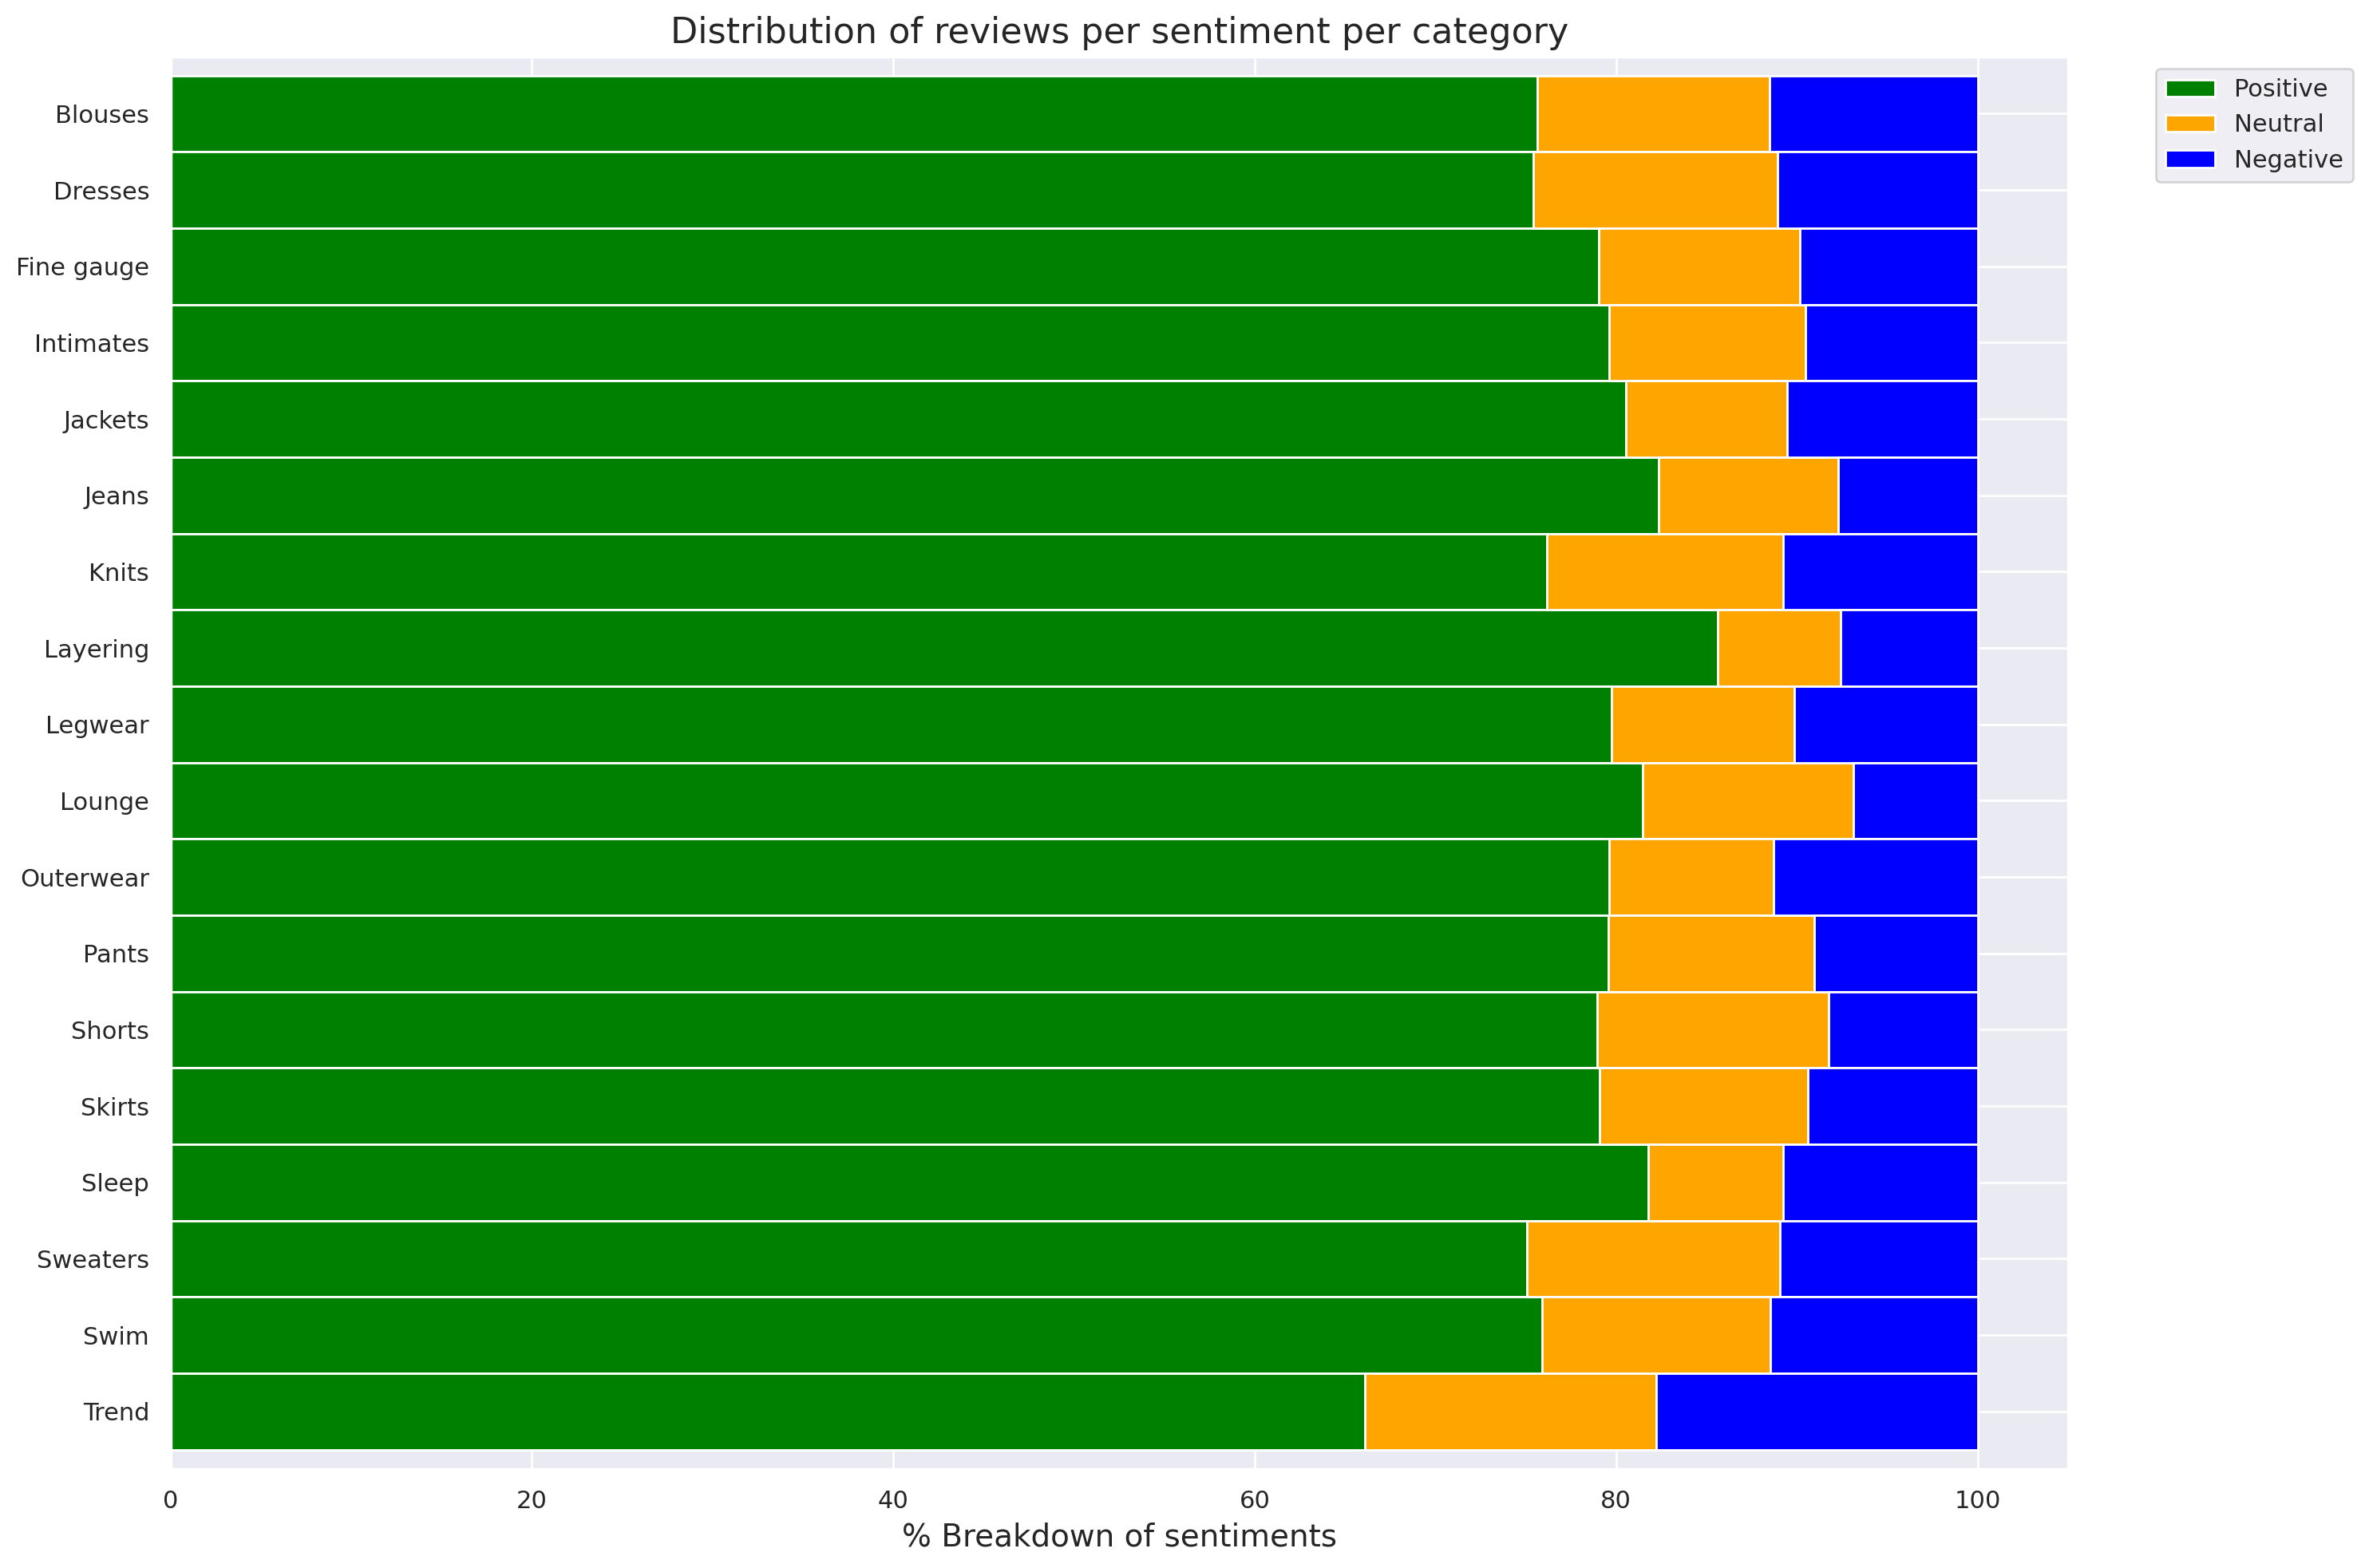

In [48]:
categories = df_distribution_pct.index

# Plot bars
plt.figure(figsize=(10,5))

df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue'])

plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['Positive', 
                   'Neutral', 
                   'Negative'])

plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('distribution_sentiment_per_category.png', dpi=300)
plt.show()

In [49]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-883663531372/images/distribution_sentiment_per_category.png'

### Analyzing the distribution of review word counts

In [50]:
statement_num_words = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}
""".format(table_name)

print(statement_num_words)



    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words

    FROM reviews




In [51]:
%%time
df_num_words = wr.athena.read_sql_query(
    sql=statement_num_words,
    database=database_name
)

CPU times: user 273 ms, sys: 16.6 ms, total: 290 ms

Wall time: 3.54 s


In [52]:
summary = df_num_words["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count      22626.0
mean     62.709847
std      29.993735
min            2.0
10%           22.0
20%           33.0
30%           42.0
40%           51.0
50%           61.0
60%           72.0
70%           86.0
80%           97.0
90%          103.0
100%         122.0
max          122.0
Name: num_words, dtype: Float64

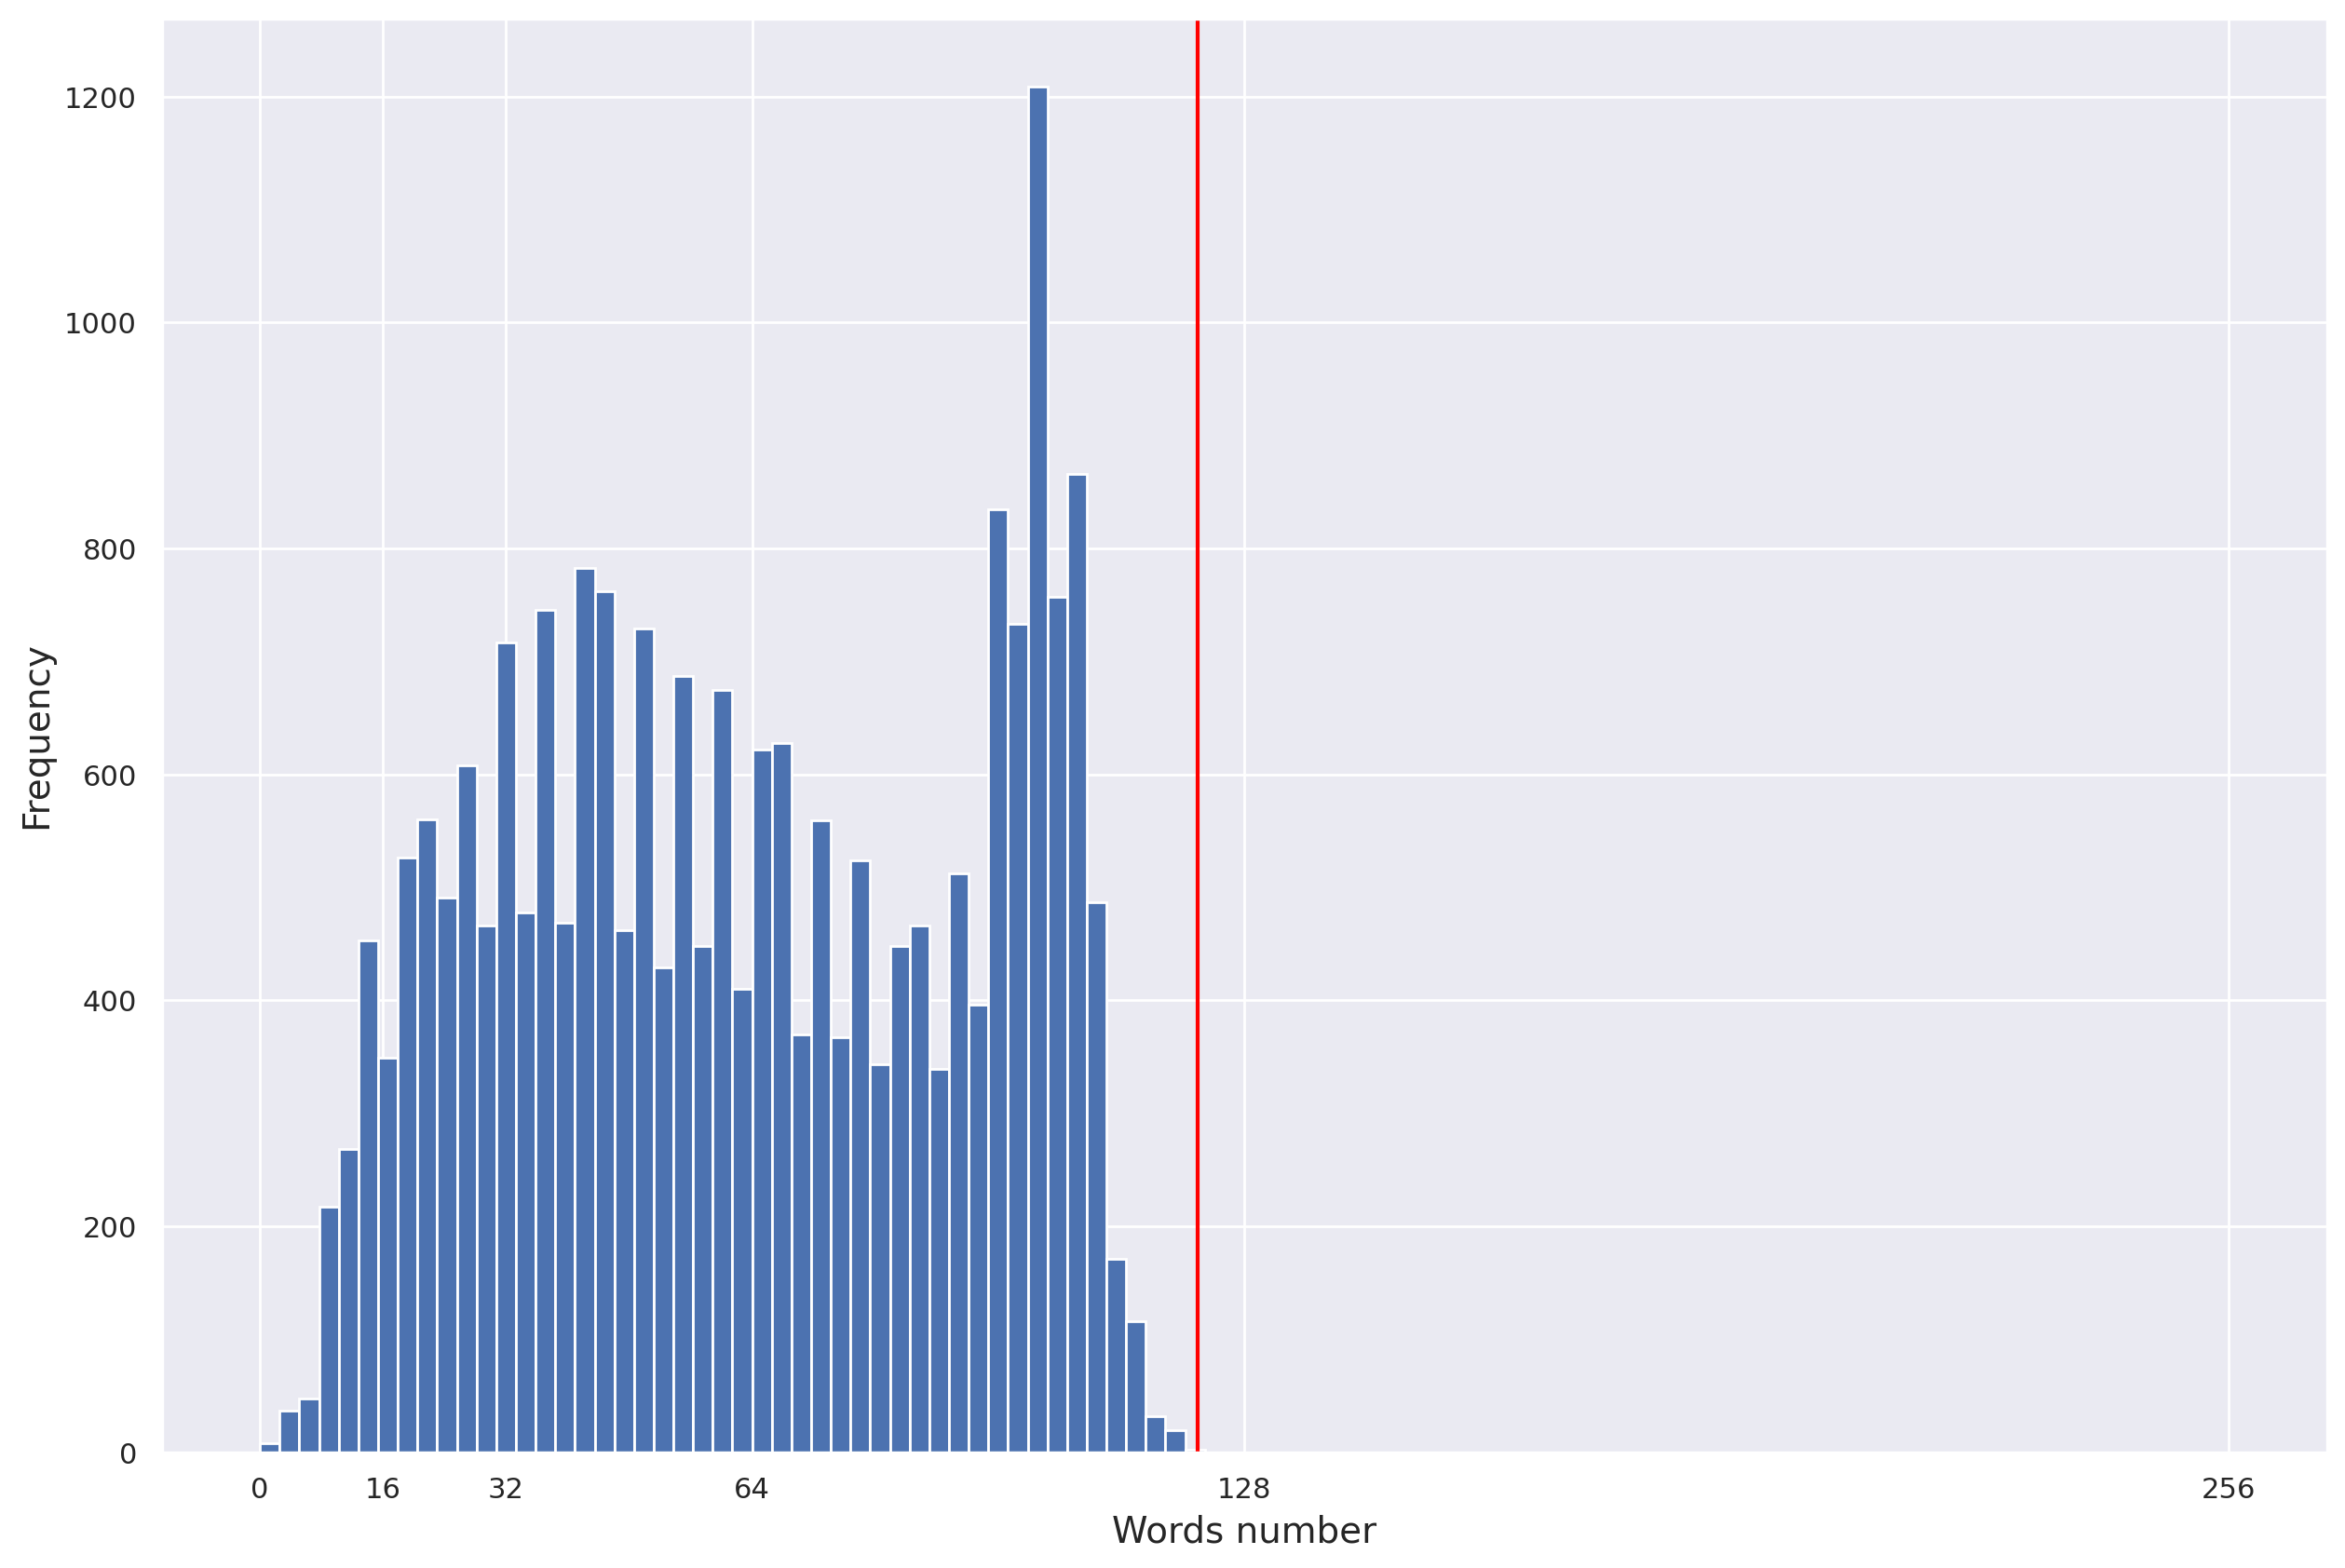

In [53]:
df_num_words["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["100%"], c="red"
)

plt.xlabel("Words number", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.savefig('distribution_num_words_per_review.png', dpi=300)
plt.show()

In [54]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_num_words_per_review.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-883663531372/images/distribution_num_words_per_review.png'

# Detect data bias with Amazon SageMaker Clarify

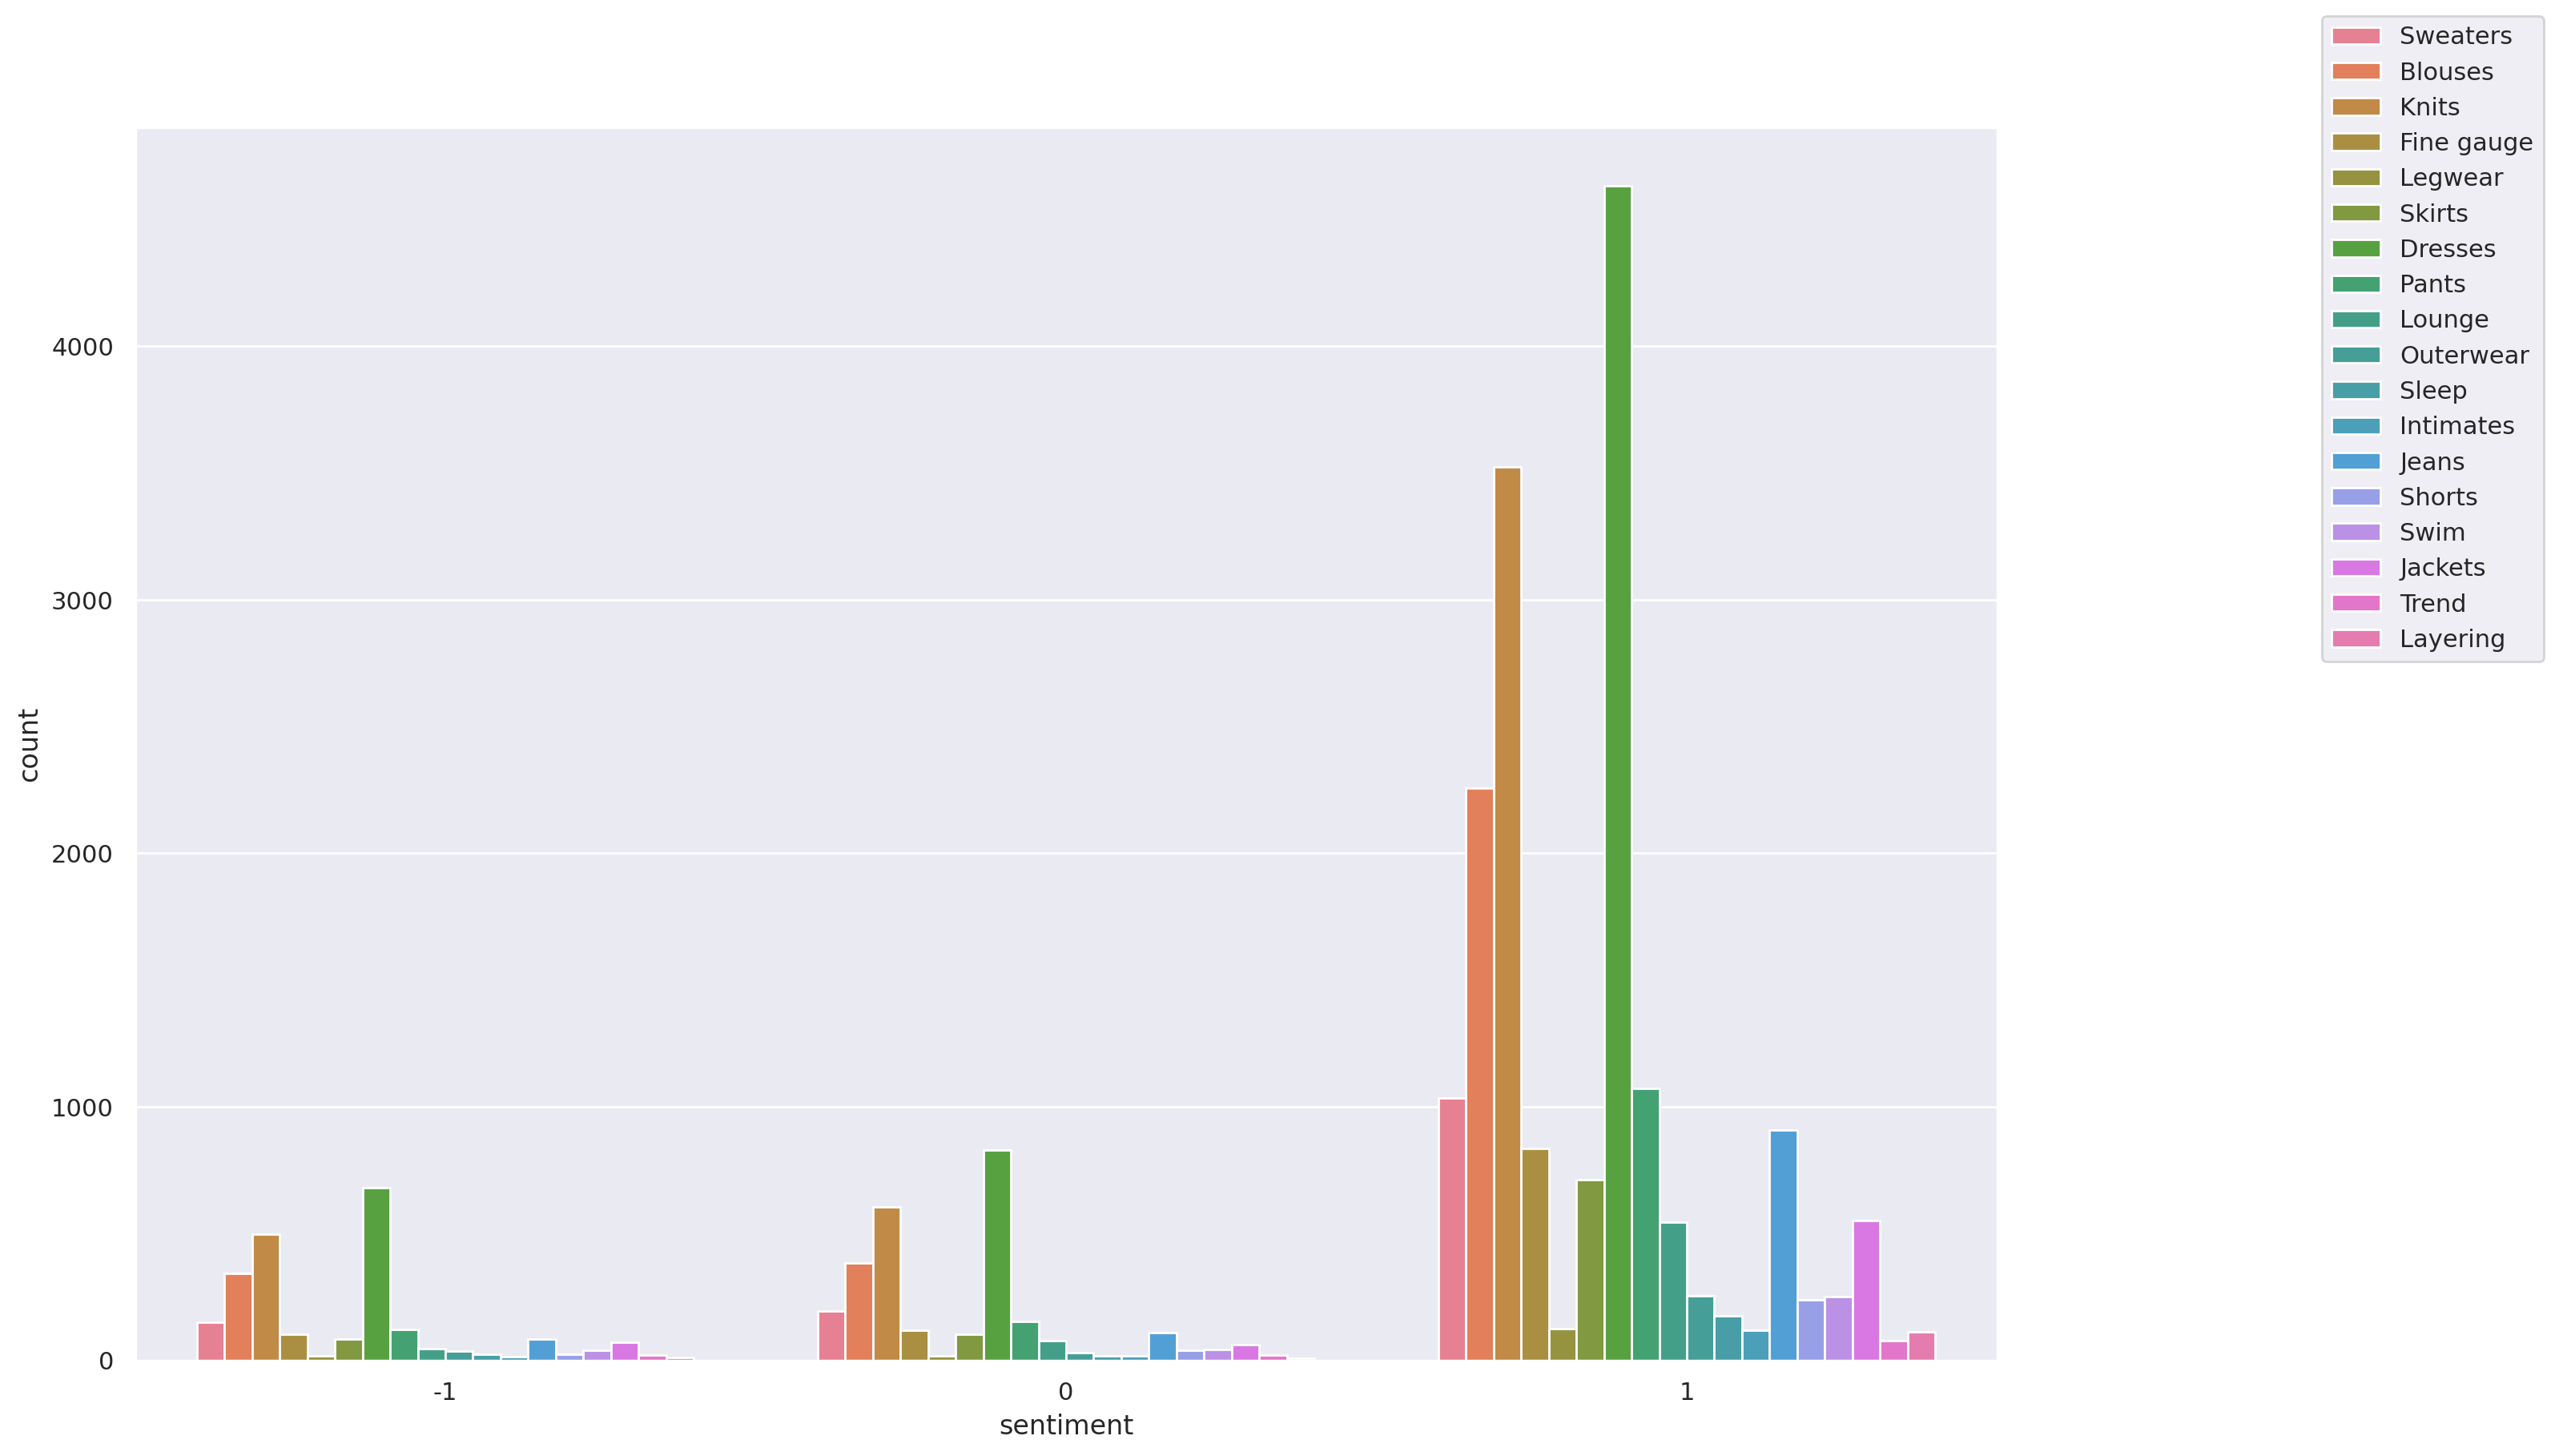

In [55]:
sns.countplot(data=df, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

### Upload the dataset to S3 bucket

In [56]:
data_s3_uri_unbalanced = sess.upload_data(bucket=bucket, 
                               key_prefix='bias/unbalanced', 
                               path='./womens_clothing_ecommerce_reviews_transformed.csv')
data_s3_uri_unbalanced

's3://sagemaker-us-east-1-883663531372/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv'

In [57]:
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

## Analyze class imbalance on the dataset with Amazon SageMaker Clarify

### Configure a `DataConfig`

In [58]:
bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    s3_data_input_path=data_s3_uri_unbalanced, 
    s3_output_path=bias_report_unbalanced_output_path, 
    label='sentiment', 
    headers=df.columns.to_list(),
    dataset_type='text/csv'
)

### Configure a `BiasConfig`

In [59]:
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

### Configure Amazon SageMaker Clarify as a processing job

In [60]:
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

### Run the Amazon SageMaker Clarify processing job

In [61]:
clarify_processor_unbalanced.run_pre_training_bias(
    data_config=data_config_unbalanced, 
    data_bias_config=bias_config_unbalanced, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)

INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2024-08-05-09-07-37-123


In [62]:
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name
print(run_unbalanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2024-08-05-09-07-37-123


### Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset

In [63]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_unbalanced_bias_processing_job_name)))


In [64]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [65]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [66]:
%%time
running_processor.wait(logs=False)

...........................................................!CPU times: user 253 ms, sys: 32.7 ms, total: 286 ms

Wall time: 5min 4s


### Analyze unbalanced bias report

In [67]:
!aws s3 ls $bias_report_unbalanced_output_path/

2024-08-05 09:12:02      31732 analysis.json

2024-08-05 09:07:38        346 analysis_config.json

2024-08-05 09:12:02    1257936 report.html

2024-08-05 09:12:02     995353 report.ipynb

2024-08-05 09:12:02     868461 report.pdf


In [68]:
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./generated_bias_report/unbalanced/

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/unbalanced/analysis_config.json to generated_bias_report/unbalanced/analysis_config.json

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/unbalanced/report.html to generated_bias_report/unbalanced/report.html

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/unbalanced/analysis.json to generated_bias_report/unbalanced/analysis.json

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/unbalanced/report.pdf to generated_bias_report/unbalanced/report.pdf

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/unbalanced/report.ipynb to generated_bias_report/unbalanced/report.ipynb


In [69]:
display(HTML('<b>Review <a target="blank" href="./generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

## Balance the dataset by `product_category` and `sentiment`

In [70]:
df_grouped_by = df.groupby(['sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

/tmp/ipykernel_102/2538192702.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

  df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))


In [71]:
df_balanced

sentiment                                        review_body  \
sentiment                                                                      
-1        0            -1  I didn't really understand the other reviews u...   
          1            -1  The cups on this suit are  ridiculous.  unless...   
          2            -1  What an adorable and frustrating skirt! i'm no...   
          3            -1  This dress runs very large. i am 5'4 and 120 l...   
          4            -1  I'm not sure why this dress is getting great r...   
...                   ...                                                ...   
1         2365          1  My favorite shirt!!! i wear it when i don't wa...   
          2366          1  The only negative thing i have to say is that ...   
          2367          1  These jeans look great with everything and fit...   
          2368          1  Simple  classic  figure flattering  and reason...   
          2369          1  This dress was almost perfect  but the white w...   

               product_category  
sentiment                        
-1        0             Blouses  
          1                Swim  
          2              Skirts  
          3             Dresses  
          4             Dresses  
...                         ...  
1         2365            Knits  
          2366          Blouses  
          2367            Jeans  
          2368          Dresses  
          2369          Dresses  

[7110 rows x 3 columns]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


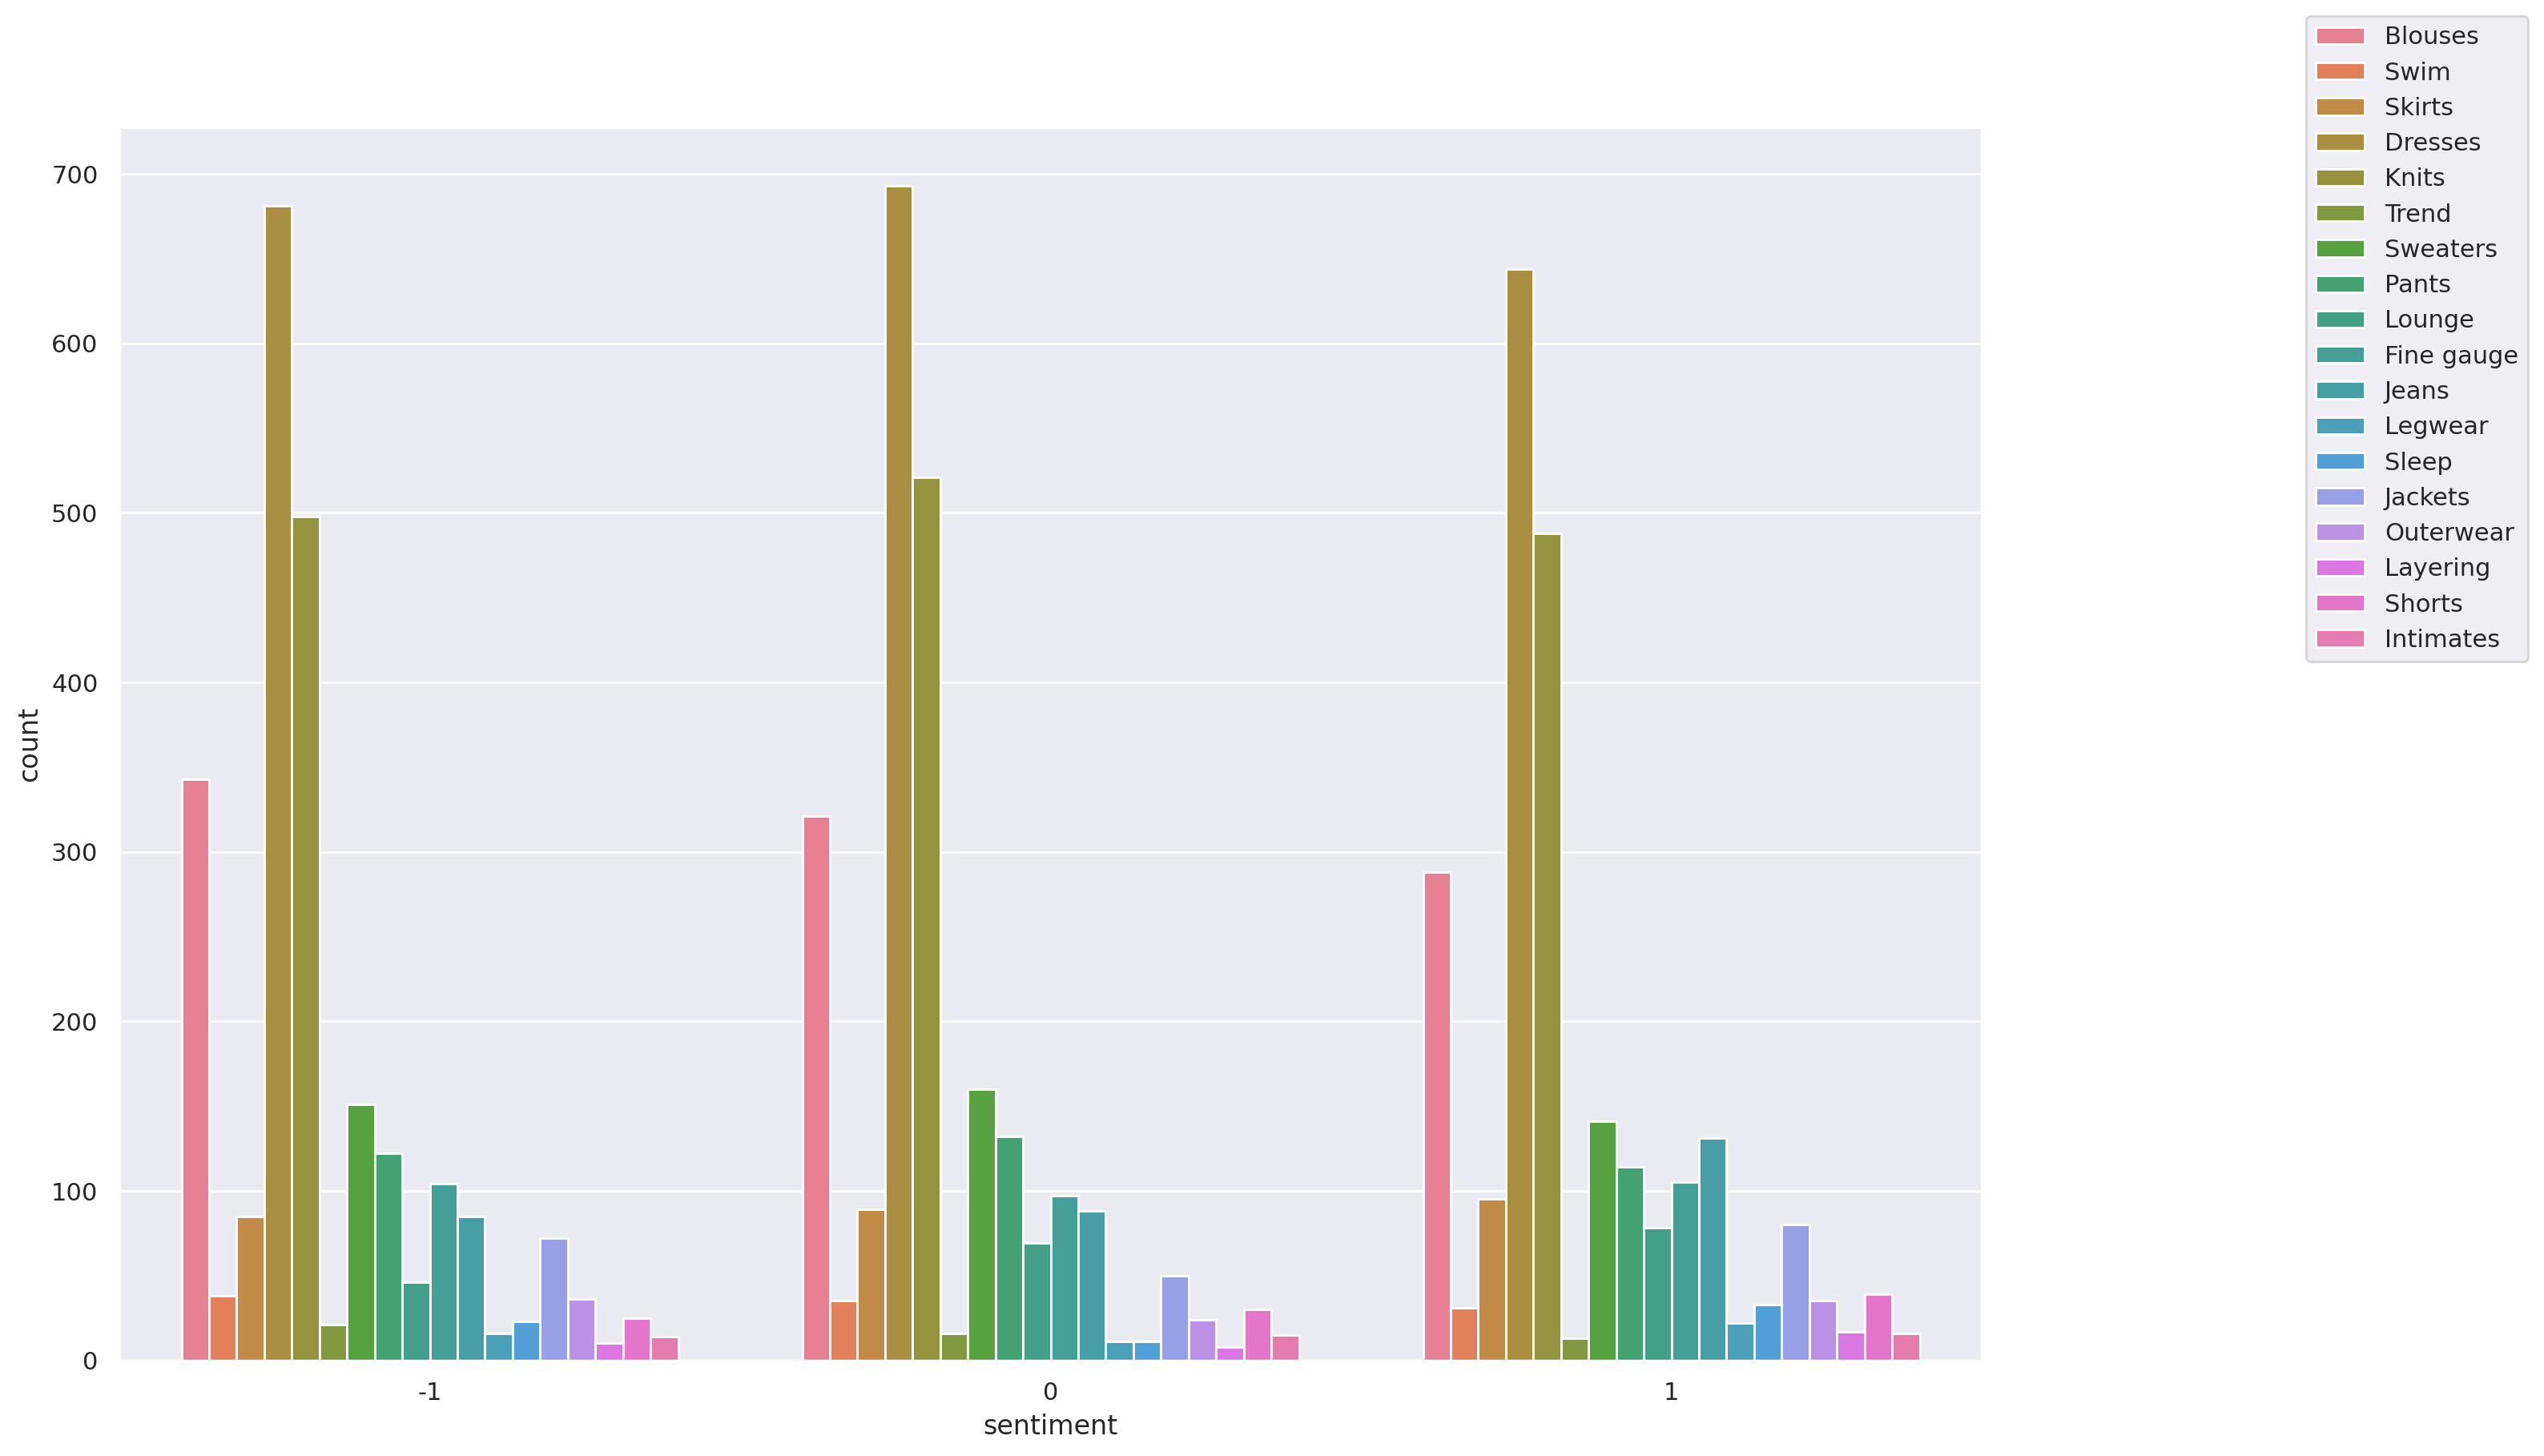

In [72]:
# Visualize the distribution of review sentiment in the balanced dataset.
sns.countplot(data=df_balanced, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))


## Analyze bias on balanced dataset with Amazon SageMaker Clarify

In [73]:
path_balanced = './womens_clothing_ecommerce_reviews_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)

data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='bias/balanced', path=path_balanced)
data_s3_uri_balanced

's3://sagemaker-us-east-1-883663531372/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv'

In [74]:
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

### Configure a `DataConfig`

In [75]:
bias_report_balanced_output_path = 's3://{}/bias/generated_bias_report/balanced'.format(bucket)

data_config_balanced = clarify.DataConfig(
    s3_data_input_path=data_s3_uri_balanced, 
    s3_output_path=bias_report_balanced_output_path, 
    label='sentiment', 
    headers=df_balanced.columns.to_list(),
    dataset_type='text/csv'
)

### Configure `BiasConfig`

In [76]:
bias_config_balanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

### Configure SageMaker Clarify as a processing job

In [77]:
clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Run the Amazon SageMaker Clarify processing job

In [78]:
clarify_processor_balanced.run_pre_training_bias(
    data_config=data_config_balanced, 
    data_bias_config=bias_config_balanced, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['sentiment', 'review_body', 'product_category'], 'label': 'sentiment', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'product_category'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}

INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2024-08-05-09-12-47-107


In [79]:
run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
print(run_balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2024-08-05-09-12-47-107


### Run and review the Clarify processing job on the balanced dataset

In [80]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))

In [81]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_balanced_bias_processing_job_name)))

In [82]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [83]:
%%time

running_processor.wait(logs=False)

...........................................................!CPU times: user 265 ms, sys: 24.5 ms, total: 289 ms

Wall time: 5min 4s


### Analyze balanced bias report

In [84]:
!aws s3 ls $bias_report_balanced_output_path/

2024-08-05 09:17:19      31715 analysis.json

2024-08-05 09:12:48        346 analysis_config.json

2024-08-05 09:17:19    1223291 report.html

2024-08-05 09:17:19     960708 report.ipynb

2024-08-05 09:17:19     855211 report.pdf


In [85]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/balanced/

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/balanced/analysis_config.json to generated_bias_report/balanced/analysis_config.json

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/balanced/report.pdf to generated_bias_report/balanced/report.pdf

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/balanced/analysis.json to generated_bias_report/balanced/analysis.json

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/balanced/report.ipynb to generated_bias_report/balanced/report.ipynb

download: s3://sagemaker-us-east-1-883663531372/bias/generated_bias_report/balanced/report.html to generated_bias_report/balanced/report.html


In [86]:
display(HTML('<b>Review <a target="blank" href="./generated_bias_report/balanced/report.html">balanced bias report</a></b>'))

# Training a model with Amazon SageMaker Autopilot

In [87]:
!aws s3 cp 's3://reviews-analysis/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv' ./

fatal error: An error occurred (403) when calling the HeadObject operation: Forbidden


In [88]:
path = './womens_clothing_ecommerce_reviews_balanced.csv'

df = pd.read_csv(path, delimiter=',')
df

,sentiment,review_body,product_category
0,-1,I didn't really understand the other reviews u...,Blouses
1,-1,The cups on this suit are ridiculous. unless...,Swim
2,-1,What an adorable and frustrating skirt! i'm no...,Skirts
3,-1,This dress runs very large. i am 5'4 and 120 l...,Dresses
4,-1,I'm not sure why this dress is getting great r...,Dresses
...,...,...,...
7105,1,My favorite shirt!!! i wear it when i don't wa...,Knits
7106,1,The only negative thing i have to say is that ...,Blouses
7107,1,These jeans look great with everything and fit...,Jeans
7108,1,Simple classic figure flattering and reason...,Dresses


In [89]:
path_autopilot = './womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

df[['sentiment', 'review_body']].to_csv(path_autopilot, 
                                        sep=',', 
                                        index=False)

## Configuring the Autopilot job

In [90]:
autopilot_train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='autopilot/data', path=path_autopilot)
autopilot_train_s3_uri

's3://sagemaker-us-east-1-883663531372/autopilot/data/womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv'

In [91]:
!aws s3 ls $autopilot_train_s3_uri

2024-08-05 09:17:59    2268824 womens_clothing_ecommerce_reviews_balanced_for_autopilot.csv


###  S3 output for generated assets
S3 output path for the Autopilot outputs. This includes Jupyter notebooks (analysis), Python scripts (feature engineering), and trained models.

In [92]:
model_output_s3_uri = 's3://{}/autopilot'.format(bucket)

print(model_output_s3_uri)

s3://sagemaker-us-east-1-883663531372/autopilot


In [93]:
timestamp = int(time.time())

auto_ml_job_name = 'automl-dm-{}'.format(timestamp)

In [94]:
max_candidates = 3

automl = sagemaker.automl.automl.AutoML(
    target_attribute_name='sentiment', 
    base_job_name=auto_ml_job_name, 
    output_path=model_output_s3_uri, 
    max_candidates=max_candidates,
    sagemaker_session=sess,
    role=role,
    max_runtime_per_training_job_in_seconds=1200,
    total_job_runtime_in_seconds=7200
)

## Launching the Autopilot job

In [95]:
automl.fit(
    autopilot_train_s3_uri, 
    job_name=auto_ml_job_name, 
    wait=False, 
    logs=False
)

INFO:sagemaker:Creating auto-ml-job with name: automl-dm-1722849480


## Tracking Autopilot job progress

### Autopilot job description

In [96]:
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

### Autopilot job status

In [97]:
while 'AutoMLJobStatus' not in job_description_response.keys() and 'AutoMLJobSecondaryStatus' not in job_description_response.keys():
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job has not yet started. Please wait. ')
    # function `json.dumps` encodes JSON string for printing.
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for Autopilot job to start...')
    sleep(15)

print('[OK] AutoML job started.')

[OK] AutoML job started.


### Reviewing the SageMaker processing jobs

In [98]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/">processing jobs</a></b>'.format(region)))

### Waiting for the data analysis step to finish

In [99]:
%%time

job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']

if job_status not in ('Stopped', 'Failed'):
    while job_status in ('InProgress') and job_sec_status in ('Starting', 'AnalyzingData'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(15)
    print('[OK] Data analysis phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress Starting

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress AnalyzingData

InProgress FeatureEngineering

[OK] Data analysis phase completed.



{

    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:883663531372:automl-job/automl-dm-1722849480",

   

### Generated notebooks

In [100]:
# getting the information about the running Autopilot job
job_description_response =  automl.describe_auto_ml_job(job_name=auto_ml_job_name)

# keeping in the while loop until the Autopilot job artifacts will be generated
while 'AutoMLJobArtifacts' not in job_description_response.keys(): 
    # update the information about the running Autopilot job
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job has not yet generated the artifacts. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for AutoMLJobArtifacts...')
    time.sleep(15)

print('[OK] AutoMLJobArtifacts generated.')

[OK] AutoMLJobArtifacts generated.


In [101]:
job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)

while 'DataExplorationNotebookLocation' not in job_description_response['AutoMLJobArtifacts']: 
    # update the information about the running Autopilot job
    job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name) 
    print('[INFO] Autopilot job has not yet generated the notebooks. Please wait. ')
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print('[INFO] Waiting for DataExplorationNotebookLocation...')
    time.sleep(15)

print('[OK] DataExplorationNotebookLocation found.')   

[OK] DataExplorationNotebookLocation found.


In [102]:

generated_resources = job_description_response['AutoMLJobArtifacts']['DataExplorationNotebookLocation']
download_path = generated_resources.rsplit('/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb')[0]
job_id = download_path.rsplit('/', 1)[-1]

if not job_id: 
    print('No AutoMLJobArtifacts found.')
else: 
    display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/autopilot/{}/sagemaker-automl-candidates/{}/">generated notebooks</a> in S3 bucket</b>'.format(bucket, auto_ml_job_name, job_id)))

## Feature engineering

In [103]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    while job_status == 'InProgress' and job_sec_status == 'FeatureEngineering': 
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Feature engineering phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress

FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgress FeatureEngineering

InProgr

## Model training and tuning

In [104]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/">hyper-parameter tuning jobs</a></b>'.format(region)))

### Waiting for training and tuning

In [105]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print(job_status)
print(job_sec_status)
if job_status not in ('Stopped', 'Failed'):
    while job_status == 'InProgress' and job_sec_status == 'ModelTuning': 
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print(job_status, job_sec_status)
        time.sleep(5)
    print('[OK] Model tuning phase completed.\n')
    
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))


InProgress

ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress ModelTuning

InProgress Mode

In [106]:
%%time

job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
pprint(job_description_response)
job_status = job_description_response['AutoMLJobStatus']
job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
print('Job status:  {}'.format(job_status))
print('Secondary job status:  {}'.format(job_sec_status))
if job_status not in ('Stopped', 'Failed'):
    while job_status not in ('Completed'):
        job_description_response = automl.describe_auto_ml_job(job_name=auto_ml_job_name)
        job_status = job_description_response['AutoMLJobStatus']
        job_sec_status = job_description_response['AutoMLJobSecondaryStatus']
        print('Job status:  {}'.format(job_status))
        print('Secondary job status:  {}'.format(job_sec_status))        
        time.sleep(10)
    print('[OK] Autopilot job completed.\n')
else:
    print('Job status: {}'.format(job_status))
    print('Secondary job status: {}'.format(job_status))

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:883663531372:automl-job/automl-dm-1722849480',

 'AutoMLJobArtifacts': {'CandidateDefinitionNotebookLocation': 's3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/sagemaker-automl-candidates/automl-dm-1722849480-pr-1-629535d7dc6d4a22ac3659c215fb09fc1cf5f/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb',

                        'DataExplorationNotebookLocation': 's3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/sagemaker-automl-candidates/automl-dm-1722849480-pr-1-629535d7dc6d4a22ac3659c215fb09fc1cf5f/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb'},

 'AutoMLJobConfig': {'CompletionCriteria': {'MaxAutoMLJobRuntimeInSeconds': 7200,

                                            'MaxCandidates': 3,

                                            'MaxRuntimePerTrainingJobInSeconds': 1200},

                     'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}},

 'Aut

### Comparing model candidates

In [107]:
candidates = automl.list_candidates(
    job_name=auto_ml_job_name, 
    sort_by='FinalObjectiveMetricValue' 
)

In [108]:
while candidates == []:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating the candidates. Please wait.')
    time.sleep(10)

print('[OK] Candidates generated.') 

[OK] Candidates generated.


In [109]:
print(candidates[0].keys())

dict_keys(['CandidateName', 'FinalAutoMLJobObjectiveMetric', 'ObjectiveStatus', 'CandidateSteps', 'CandidateStatus', 'InferenceContainers', 'CreationTime', 'EndTime', 'LastModifiedTime', 'CandidateProperties'])


In [110]:
while 'CandidateName' not in candidates[0]:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating CandidateName. Please wait. ')
    sleep(10)

print('[OK] CandidateName generated.')

[OK] CandidateName generated.


In [111]:
while 'FinalAutoMLJobObjectiveMetric' not in candidates[0]:
    candidates = automl.list_candidates(job_name=auto_ml_job_name)
    print('[INFO] Autopilot job is generating FinalAutoMLJobObjectiveMetric. Please wait. ')
    sleep(10)

print('[OK] FinalAutoMLJobObjectiveMetric generated.')

[OK] FinalAutoMLJobObjectiveMetric generated.


In [112]:
print(json.dumps(candidates, indent=4, sort_keys=True, default=str))

[

    {

        "CandidateName": "automl-dm-1722849480Q9rc8wnhm1UA-002-21b6662a",

        "CandidateProperties": {

            "CandidateArtifactLocations": {

                "Explainability": "s3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/documentation/explainability/output",

                "ModelInsights": "s3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/documentation/model_monitor/output"

            },

            "CandidateMetrics": [

                {

                    "MetricName": "F1macro",

                    "Set": "Validation",

                    "StandardMetricName": "F1macro",

                    "Value": 0.6261399984359741

                },

                {

                    "MetricName": "PrecisionMacro",

                    "Set": "Validation",

                    "StandardMetricName": "PrecisionMacro",

                    "Value": 0.6252999901771545

                },

                {

         

In [113]:
print("metric " + str(candidates[0]['FinalAutoMLJobObjectiveMetric']['MetricName']))

for index, candidate in enumerate(candidates):
    print(str(index) + "  " 
        + candidate['CandidateName'] + "  " 
        + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))

metric validation:accuracy

0  automl-dm-1722849480Q9rc8wnhm1UA-002-21b6662a  0.6275699734687805

1  automl-dm-1722849480Q9rc8wnhm1UA-001-ce899e27  0.3997200131416321

2  automl-dm-1722849480Q9rc8wnhm1UA-003-1170d53e  0.3933899998664856


### Reviewing best candidate

In [114]:
candidates = automl.list_candidates(job_name=auto_ml_job_name)

if candidates != []:
    best_candidate = automl.best_candidate(
        job_name=auto_ml_job_name
    )
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))

{

    "CandidateName": "automl-dm-1722849480Q9rc8wnhm1UA-002-21b6662a",

    "CandidateProperties": {

        "CandidateArtifactLocations": {

            "Explainability": "s3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/documentation/explainability/output",

            "ModelInsights": "s3://sagemaker-us-east-1-883663531372/autopilot/automl-dm-1722849480/documentation/model_monitor/output"

        },

        "CandidateMetrics": [

            {

                "MetricName": "F1macro",

                "Set": "Validation",

                "StandardMetricName": "F1macro",

                "Value": 0.6261399984359741

            },

            {

                "MetricName": "PrecisionMacro",

                "Set": "Validation",

                "StandardMetricName": "PrecisionMacro",

                "Value": 0.6252999901771545

            },

            {

                "MetricName": "Accuracy",

                "Set": "Validation",

               

In [115]:
while 'CandidateName' not in best_candidate:
    best_candidate = automl.best_candidate(job_name=auto_ml_job_name)
    print('[INFO] Autopilot Job is generating BestCandidate CandidateName. Please wait. ')
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print('[OK] BestCandidate CandidateName generated.')  

[OK] BestCandidate CandidateName generated.


In [116]:
# Checking the existence of the metric value for the best candidate.
while 'FinalAutoMLJobObjectiveMetric' not in best_candidate:
    best_candidate = automl.best_candidate(job_name=auto_ml_job_name)
    print('[INFO] Autopilot Job is generating BestCandidate FinalAutoMLJobObjectiveMetric. Please wait. ')
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print('[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.')  

[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.


In [117]:
best_candidate_identifier = best_candidate['CandidateName']
print("Candidate name: " + best_candidate_identifier)
print("Metric name: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("Metric value: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

Candidate name: automl-dm-1722849480Q9rc8wnhm1UA-002-21b6662a

Metric name: validation:accuracy

Metric value: 0.6275699734687805


## Reviewing all output in S3 bucket

Artifacts generated by Autopilot including the following:
```
data-processor-models/        # "models" learned to transform raw data into features 
documentation/                # explainability and other documentation about model
preprocessed-data/            # data for train and validation
sagemaker-automl-candidates/  # candidate models which autopilot compares
transformed-data/             # candidate-specific data for train and validation
tuning/                       # candidate-specific tuning results
validations/                  # validation results
```

In [118]:

display(HTML('<b>Review all <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=autopilot/{}/">output in S3</a></b>'.format(bucket, region, auto_ml_job_name)))

## Deploying and testing best candidate of autopilot model

In [119]:
inference_response_keys = ['predicted_label', 'probability']

In [120]:
autopilot_model = automl.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    candidate=best_candidate,
    inference_response_keys=inference_response_keys,
    predictor_cls=sagemaker.predictor.Predictor,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

print('\nEndpoint name:  {}'.format(autopilot_model.endpoint_name))

INFO:sagemaker:Creating model with name: sagemaker-sklearn-automl-2024-08-05-09-47-36-190

INFO:sagemaker:Creating endpoint-config with name sagemaker-sklearn-automl-2024-08-05-09-47-36-190

INFO:sagemaker:Creating endpoint with name sagemaker-sklearn-automl-2024-08-05-09-47-36-190


--------!

Endpoint name:  sagemaker-sklearn-automl-2024-08-05-09-47-36-190


In [121]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, autopilot_model.endpoint_name)))

### Testing the autopilot model

In [122]:
#sm_runtime = boto3.client('sagemaker-runtime')

review_list = ['This product is great!',
               'OK, but not great.',
               'This is not the right product.']

for review in review_list:
    
    # remove commas from the review since we're passing the inputs as a CSV
    review = review.replace(",", "")

    response = sm_runtime.invoke_endpoint(
        EndpointName=autopilot_model.endpoint_name, # endpoint name
        ContentType='text/csv', # type of input data
        Accept='text/csv', # type of the inference in the response
        Body=review # review text
        )

    response_body=response['Body'].read().decode('utf-8').strip().split(',')

    print('Review: ', review, ' Predicated class: {}'.format(response_body[0]))

print("(-1 = Negative, 0=Neutral, 1=Positive)")

Review:  This product is great!  Predicated class: 1

Review:  OK but not great.  Predicated class: 0

Review:  This is not the right product.  Predicated class: -1

(-1 = Negative, 0=Neutral, 1=Positive)


# Training a text classifier using Amazon SageMaker BlazingText built-in algorithm

# Prepare and transform dataset

The BlazingText format is as follows:

```
__label__<label> "<features>"
```

In [123]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [124]:
sentence = "I'm not a fan of this product!"

tokens = nltk.word_tokenize(sentence)
print(tokens)

['I', "'m", 'not', 'a', 'fan', 'of', 'this', 'product', '!']


In [125]:
def tokenize(review):
    # delete commas and quotation marks, apply tokenization and join back into a string separating by spaces
    return ' '.join([str(token) for token in nltk.word_tokenize(str(review).replace(',', '').replace('"', '').lower())])
    
def prepare_data(df):
    df['sentiment'] = df['sentiment'].map(lambda sentiment : '__label__{}'.format(str(sentiment).replace('__label__', '')))
    df['review_body'] = df['review_body'].map(lambda review : tokenize(review))
    return df

In [126]:
# create a sample dataframe
df_example = pd.DataFrame({
    'sentiment':[-1, 0, 1], 
    'review_body':[
        "I don't like this product!", 
        "this product is ok", 
        "I do like this product!"]
})

# test the prepare_data function
print(prepare_data(df_example))

     sentiment                   review_body

0  __label__-1  i do n't like this product !

1   __label__0            this product is ok

2   __label__1      i do like this product !


In [127]:
df_blazingtext = df[['sentiment', 'review_body']].reset_index(drop=True)
df_blazingtext = prepare_data(df_blazingtext)
df_blazingtext.head()

,sentiment,review_body
0,__label__-1,i did n't really understand the other reviews ...
1,__label__-1,the cups on this suit are ridiculous . unless ...
2,__label__-1,what an adorable and frustrating skirt ! i 'm ...
3,__label__-1,this dress runs very large . i am 5 ' 4 and 12...
4,__label__-1,i 'm not sure why this dress is getting great ...


### Split the dataset into train and validation sets

In [128]:
# Split all data into 90% train and 10% holdout
df_train, df_validation = train_test_split(df_blazingtext, 
                                           test_size=0.1,
                                           stratify=df_blazingtext['sentiment'])

In [129]:
blazingtext_train_path = './train.csv'
df_train[['sentiment', 'review_body']].to_csv(blazingtext_train_path, index=False, header=False, sep=' ')

In [130]:
blazingtext_validation_path = './validation.csv'
df_validation[['sentiment', 'review_body']].to_csv(blazingtext_validation_path, index=False, header=False, sep=' ')

### Uploadind the `train` and `validation` datasets to S3 bucket

In [131]:
train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_train_path)
validation_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_validation_path)

## Training the Blazingtext model

In [132]:
image_uri = sagemaker.image_uris.retrieve(
    region=region,
    framework='blazingtext'
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [133]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.large',
    volume_size=30,
    max_run=7200,
    sagemaker_session=sess
)

In [134]:
# The hyperparameters that have the greatest impact on word2vec objective metrics are: `learning_rate` and `vector_dim`.
estimator.set_hyperparameters(mode='supervised',   # supervised (text classification)
                              epochs=10,           # number of complete passes through the dataset: 5 - 15
                              learning_rate=0.01,  # step size for the  numerical optimizer: 0.005 - 0.01
                              min_count=2,         # discard words that appear less than this number: 0 - 100                              
                              vector_dim=300,      # number of dimensions in vector space: 32-300
                              word_ngrams=3)       # number of words in a word n-gram: 1 - 3

In [135]:
train_data = sagemaker.inputs.TrainingInput(
    train_s3_uri,
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [136]:
validation_data = sagemaker.inputs.TrainingInput(
    validation_s3_uri,
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [137]:
data_channels = {
    'train': train_data, 
    'validation': validation_data 
}

In [138]:
estimator.fit(
    inputs=data_channels,
    wait=False
)

training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

INFO:sagemaker:Creating training-job with name: blazingtext-2024-08-05-09-52-19-318


Training Job Name:  blazingtext-2024-08-05-09-52-19-318


In [139]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training job</a></b>'.format(region, training_job_name)))

In [140]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> (after about 5 minutes)</b>'.format(region, training_job_name)))

In [141]:
%%time

estimator.latest_training_job.wait(logs=False)



2024-08-05 09:52:20 Starting - Starting the training job..

2024-08-05 09:52:35 Starting - Preparing the instances for training....

2024-08-05 09:53:05 Downloading - Downloading input data.......

2024-08-05 09:53:45 Downloading - Downloading the training image..

2024-08-05 09:54:01 Training - Training image download completed. Training in progress.......

2024-08-05 09:54:36 Uploading - Uploading generated training model....................

2024-08-05 09:56:20 Completed - Training job completed

CPU times: user 245 ms, sys: 26.9 ms, total: 272 ms

Wall time: 4min 3s


In [142]:
# Review the train and validation accuracy.
estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.5176
1,0.0,validation:accuracy,0.5134


In [143]:
display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/output/?region={}&tab=overview">Trained model</a> in S3</b>'.format(bucket, training_job_name, region)))

## Deploy the BalzingText model


In [144]:
%%time

text_classifier = estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m5.large',
                                   serializer=sagemaker.serializers.JSONSerializer(),
                                   deserializer=sagemaker.deserializers.JSONDeserializer())

print()
print('Endpoint name:  {}'.format(text_classifier.endpoint_name))

INFO:sagemaker:Creating model with name: blazingtext-2024-08-05-09-56-23-828

INFO:sagemaker:Creating endpoint-config with name blazingtext-2024-08-05-09-56-23-828

INFO:sagemaker:Creating endpoint with name blazingtext-2024-08-05-09-56-23-828


------!

Endpoint name:  blazingtext-2024-08-05-09-56-23-828

CPU times: user 70.2 ms, sys: 6.24 ms, total: 76.5 ms

Wall time: 3min 33s


In [145]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, text_classifier.endpoint_name)))

# Test the BalzingText model

In [146]:
tokenized_reviews = [' '.join(nltk.word_tokenize(review)) for review in review_list]

payload = {"instances" : tokenized_reviews}
print(payload)

{'instances': ['This product is great !', 'OK , but not great .', 'This is not the right product .']}


In [147]:
predictions = text_classifier.predict(data=payload)
for prediction in predictions:
    print('Predicted class: {}'.format(prediction['label'][0].lstrip('__label__')))

Predicted class: 1

Predicted class: 1

Predicted class: -1


In [148]:
client = boto3.client('sagemaker-runtime')

# Invoke the endpoint
response = client.invoke_endpoint(
    EndpointName=text_classifier.endpoint_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)

# Print the response
result = json.loads(response['Body'].read().decode())


for prediction in result:
    print('Predicted class: {}'.format(prediction['label'][0].lstrip('__label__')))

Predicted class: 1

Predicted class: 1

Predicted class: -1
